In [201]:
import os
import warnings
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sqlalchemy import create_engine
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
sns.set_theme()
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

In [2]:
with engine.connect() as conn:
    result = conn.execute("select 'hello from remote postgres on vps!'")
    print(result.first())

('hello from remote postgres on vps!',)


In [3]:
tables = engine.table_names()
tables

/var/folders/z9/mv9ft52d0xjdby04_kkqsbfm0000gn/T/ipykernel_4903/2764942572.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  tables = engine.table_names()


['target',
 'salary',
 'work',
 'winequalityreds',
 'clients',
 'close',
 'job',
 'last',
 'loan',
 'pens']

In [26]:
for table in tables:
    locals()[f'df_{table}'] = pd.read_sql_query(f"SELECT * FROM {table}", engine)
    print(f'df_{table} added to locals and successfully read from remote sql db')

df_target added to locals and successfully read from remote sql db
df_salary added to locals and successfully read from remote sql db
df_work added to locals and successfully read from remote sql db
df_winequalityreds added to locals and successfully read from remote sql db
df_hw_clients_final_table added to locals and successfully read from remote sql db
df_clients_final_table added to locals and successfully read from remote sql db
df_clients added to locals and successfully read from remote sql db
df_close added to locals and successfully read from remote sql db
df_job added to locals and successfully read from remote sql db
df_last added to locals and successfully read from remote sql db
df_loan added to locals and successfully read from remote sql db
df_pens added to locals and successfully read from remote sql db


In [27]:
df_target.describe(include='all')

,AGREEMENT_RK,ID_CLIENT,TARGET
count,1.522300e+04,1.522300e+04,15223.000000
mean,6.540183e+07,1.068120e+08,0.119030
std,4.568181e+06,4.394646e+03,0.323835
min,5.991015e+07,1.068044e+08,0.000000
25%,6.192092e+07,1.068082e+08,0.000000
50%,6.437100e+07,1.068120e+08,0.000000
75%,6.708802e+07,1.068158e+08,0.000000
max,7.529224e+07,1.068196e+08,1.000000


In [28]:
df_target.dtypes

AGREEMENT_RK    int64
ID_CLIENT       int64
TARGET          int64
dtype: object

In [29]:
df_clients.shape

(16000, 14)

In [19]:
df_clients['ID'].nunique()

16000

In [30]:
df_clients_salary_target = df_clients.merge(df_target,
                                            how='inner',
                                            left_on='ID',
                                            right_on='ID_CLIENT').drop(columns='ID_CLIENT').merge(df_salary,
                                                                                                  how='inner',
                                                                                                  left_on='ID',
                                                                                                  right_on='ID_CLIENT').drop(columns='ID_CLIENT')

df_clients_salary_target.head()

,ID,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,FL_PRESENCE_FL,OWN_AUTO,AGREEMENT_RK,TARGET,FAMILY_INCOME,PERSONAL_INCOME
0,106805103,42,1,Среднее,Не состоял в браке,1,0,1,0,Московская область,Московская область,Московская область,1,0,60099204,1,от 20000 до 50000 руб.,25000.0
1,106809308,28,1,Среднее специальное,Состою в браке,1,1,1,0,Читинская область,Читинская область,Читинская область,0,0,62244665,0,от 10000 до 20000 руб.,10000.0
2,106805867,64,0,Среднее специальное,Состою в браке,2,0,1,1,Иркутская область,Иркутская область,Иркутская область,0,1,61050759,0,от 20000 до 50000 руб.,30000.0
3,106808779,54,1,Среднее специальное,Состою в браке,0,0,1,0,Новосибирская область,Новосибирская область,Новосибирская область,1,1,62079659,0,от 20000 до 50000 руб.,25000.0
4,106814289,26,0,Среднее специальное,Состою в браке,1,1,1,0,Красноярский край,Красноярский край,Красноярский край,1,0,66583553,0,от 10000 до 20000 руб.,15000.0


In [31]:
df_loans = df_loan.merge(df_close,
              left_on='ID_LOAN',
              right_on='ID_LOAN').groupby('ID_CLIENT').agg(LOAN_NUM_TOTAL=('ID_LOAN', 'nunique'),
                                                           LOAN_NUM_CLOSED=('CLOSED_FL', 'sum')).reset_index()

df_loans.head()

,ID_CLIENT,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
0,106804370,1,1
1,106804371,1,1
2,106804372,2,1
3,106804373,1,1
4,106804374,2,1


In [32]:
df_final = df_clients_salary_target.merge(df_loans,
                                          how='left',
                                          left_on='ID',
                                          right_on="ID_CLIENT").drop(columns=['ID',
                                                                              "ID_CLIENT"])

In [33]:
df_final.isna().sum()

AGE                        0
GENDER                     0
EDUCATION                  0
MARITAL_STATUS             0
CHILD_TOTAL                0
DEPENDANTS                 0
SOCSTATUS_WORK_FL          0
SOCSTATUS_PENS_FL          0
REG_ADDRESS_PROVINCE       0
FACT_ADDRESS_PROVINCE      0
POSTAL_ADDRESS_PROVINCE    0
FL_PRESENCE_FL             0
OWN_AUTO                   0
AGREEMENT_RK               0
TARGET                     0
FAMILY_INCOME              0
PERSONAL_INCOME            0
LOAN_NUM_TOTAL             0
LOAN_NUM_CLOSED            0
dtype: int64

In [34]:
(df_final.MARITAL_STATUS).value_counts(normalize=True)

MARITAL_STATUS
Состою в браке        0.618502
Не состоял в браке    0.237969
Разведен(а)           0.081621
Вдовец/Вдова          0.038846
Гражданский брак      0.023063
Name: proportion, dtype: float64

In [1024]:
df_final.to_sql('clients_final_table', engine)

523

Проверка

In [35]:
pd.read_sql_query(f"SELECT * FROM clients_final_table limit 5", engine)

,index,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,FL_PRESENCE_FL,OWN_AUTO,AGREEMENT_RK,TARGET,FAMILY_INCOME,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
0,0,42,1,Среднее,Не состоял в браке,1,0,1,0,Московская область,Московская область,Московская область,1,0,60099204,1,от 20000 до 50000 руб.,25000.0,1,0
1,1,28,1,Среднее специальное,Состою в браке,1,1,1,0,Читинская область,Читинская область,Читинская область,0,0,62244665,0,от 10000 до 20000 руб.,10000.0,1,0
2,2,64,0,Среднее специальное,Состою в браке,2,0,1,1,Иркутская область,Иркутская область,Иркутская область,0,1,61050759,0,от 20000 до 50000 руб.,30000.0,1,1
3,3,54,1,Среднее специальное,Состою в браке,0,0,1,0,Новосибирская область,Новосибирская область,Новосибирская область,1,1,62079659,0,от 20000 до 50000 руб.,25000.0,1,0
4,4,26,0,Среднее специальное,Состою в браке,1,1,1,0,Красноярский край,Красноярский край,Красноярский край,1,0,66583553,0,от 10000 до 20000 руб.,15000.0,2,2


## Графики для Streamlit

In [162]:
plot_folder = pathlib.Path('.').resolve().parent / 'data'

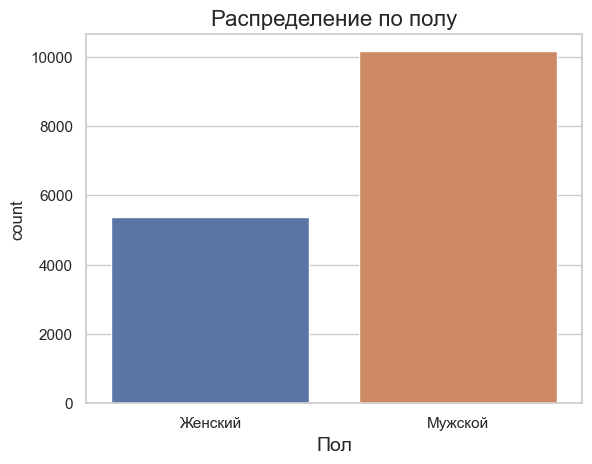

In [217]:
plt.figure()

sns.countplot(df_final, x = 'GENDER')
plt.title('Распределение по полу', fontsize=16)
plt.xlabel('Пол', fontsize=14)  
plt.xticks(ticks=[1, 0], labels=['Мужской', 'Женский'])
plt.savefig(f'{plot_folder}/gender_plot.png', dpi=900, bbox_inches="tight")


plt.show()

<Figure size 640x480 with 0 Axes>

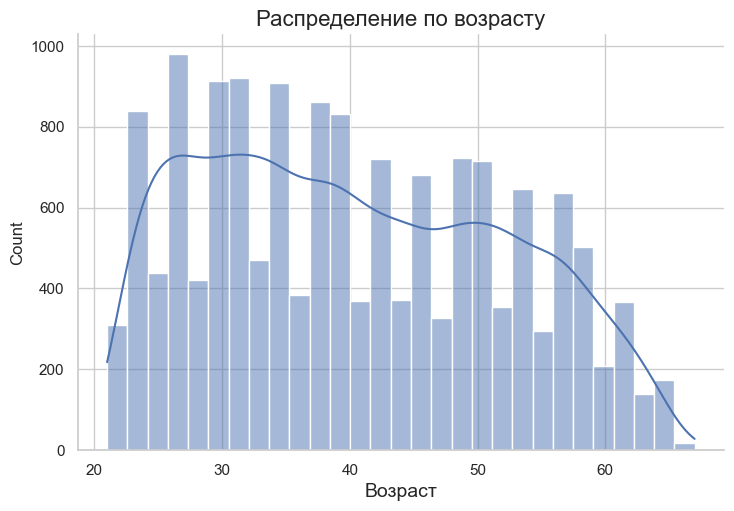

In [1056]:
plt.figure()

sns.displot(df_final, x = 'AGE', kde=True, aspect=1.5)
plt.title('Распределение по возрасту', fontsize=16)
plt.xlabel('Возраст', fontsize=14)  
plt.savefig(f'{plot_folder}/age_plot.png', dpi=900, bbox_inches="tight")
            

plt.show()

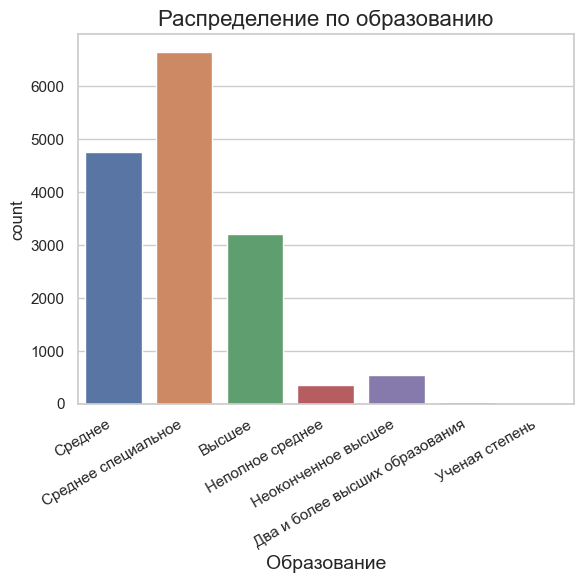

In [224]:
plt.figure()

sns.countplot(df_final, x = 'EDUCATION')
plt.title('Распределение по образованию', fontsize=16)
plt.xlabel('Образование', fontsize=14)  
plt.xticks(rotation=30, ha='right')

plt.savefig(f'{plot_folder}/ed_plot.png', dpi=900, bbox_inches="tight");

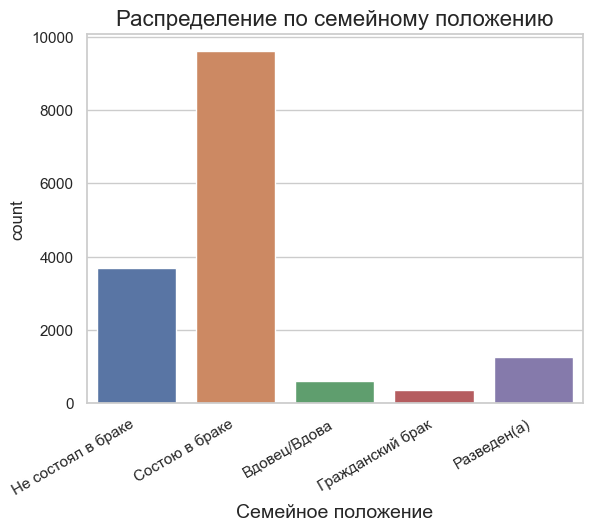

In [254]:
plt.figure()

sns.countplot(df_final, x = 'MARITAL_STATUS')
plt.title('Распределение по семейному положению', fontsize=16)
plt.xlabel('Cемейное положение', fontsize=14)  
plt.xticks(rotation=30, ha='right')

plt.savefig(f'{plot_folder}/martial_plot.png', dpi=900, bbox_inches="tight");

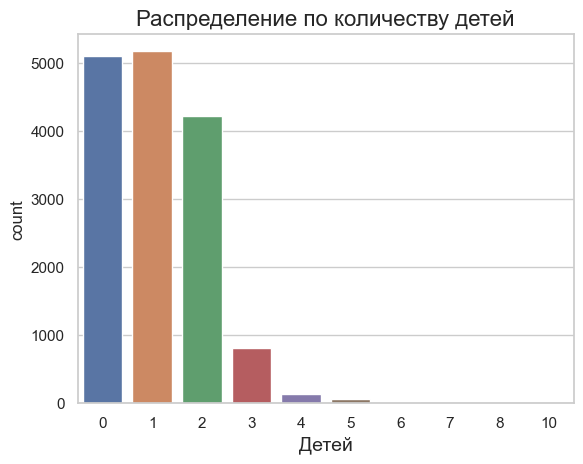

In [239]:
plt.figure()

sns.countplot(df_final, x = 'CHILD_TOTAL')
plt.title('Распределение по количеству детей', fontsize=16)
plt.xlabel('Детей', fontsize=14)  
# plt.xticks(rotation=30, ha='right')

plt.savefig(f'{plot_folder}/child_plot.png', dpi=900, bbox_inches="tight");

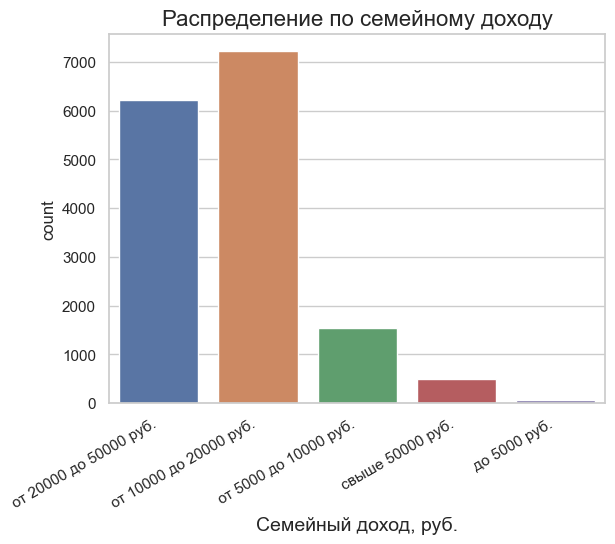

In [283]:
plt.figure()

sns.countplot(df_final, x = 'FAMILY_INCOME')
plt.title('Распределение по семейному доходу', fontsize=16)
plt.xlabel('Семейный доход, руб.', fontsize=14)  
plt.xticks(rotation=30, ha='right')

plt.savefig(f'{plot_folder}/family_income_plot.png', dpi=900, bbox_inches="tight");

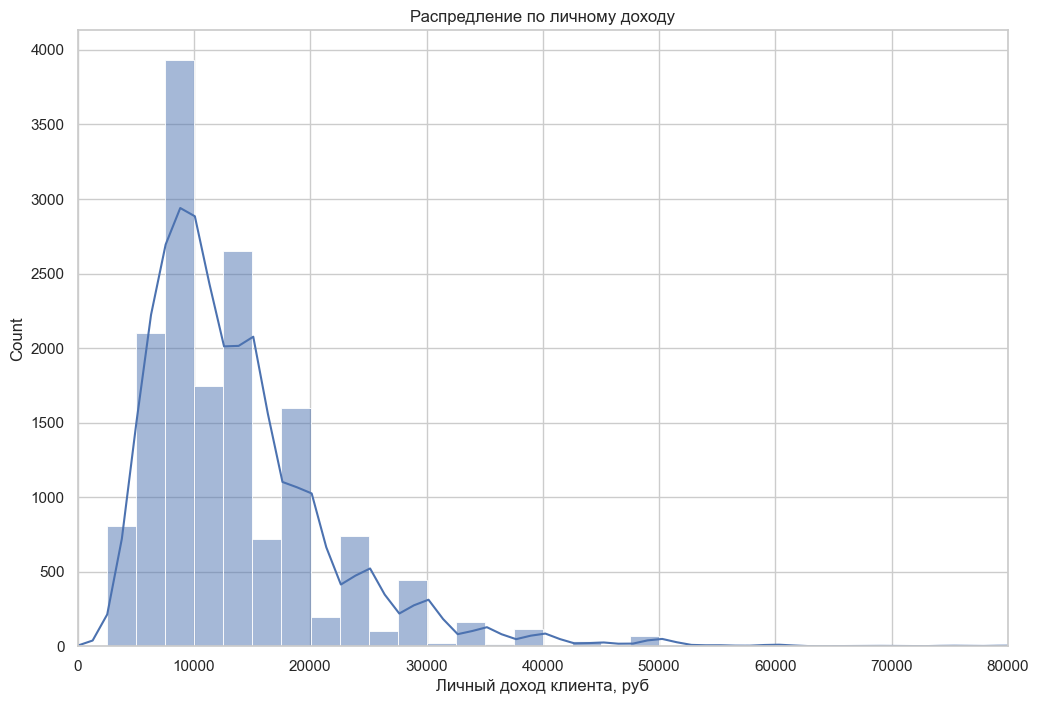

In [274]:
plt.figure(figsize=(12, 8))
sns.histplot(df_final['PERSONAL_INCOME'], bins=100, kde=True)
plt.title('Распредление по личному доходу')
plt.xlabel('Личный доход клиента, руб')
plt.ylabel('Count')
plt.xlim(0, 80000)
plt.savefig(f'{plot_folder}/income_plot.png', dpi=900, bbox_inches="tight");
plt.show()

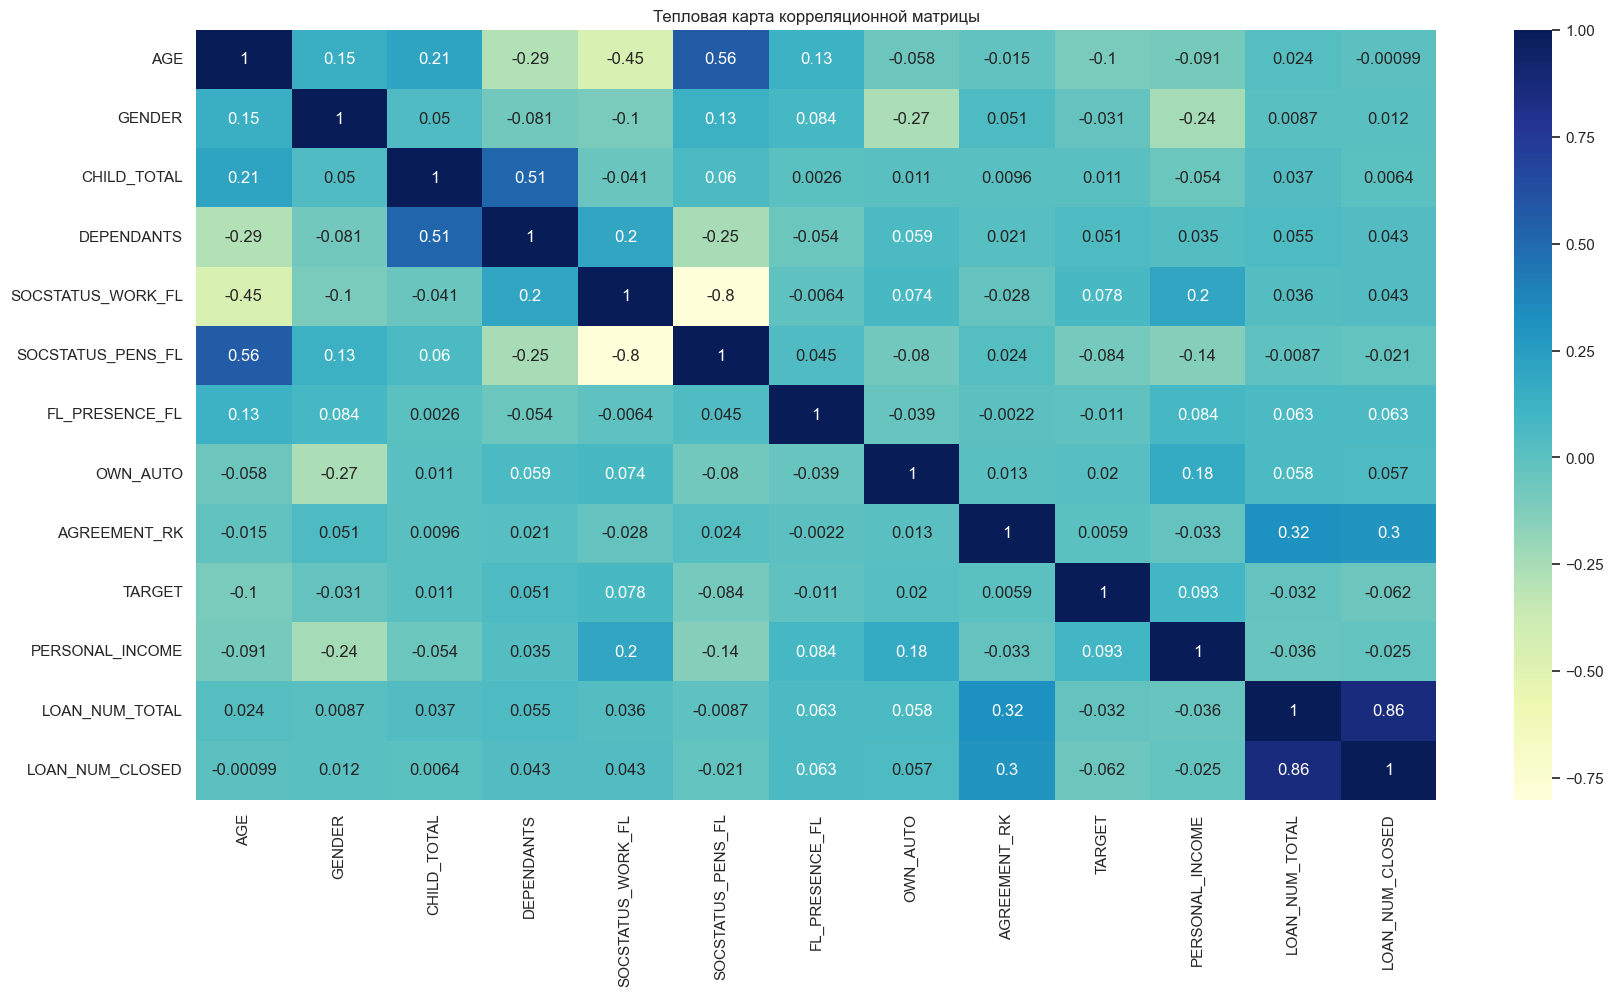

In [334]:
plt.figure(figsize=(20,10))
sns.heatmap(df_final.select_dtypes('number').corr(),
            cmap="YlGnBu",
            annot=True).set_title('Correlation')

plt.title('Тепловая карта корреляционной матрицы')
plt.savefig(f'{plot_folder}/corr_heatmap.png', dpi=900, bbox_inches="tight");
plt.show()

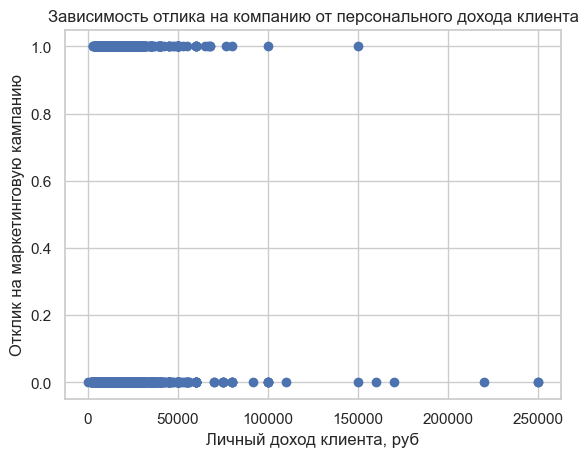

In [538]:
plt.scatter(df_final['PERSONAL_INCOME'], df_final['TARGET'])
plt.xlabel('Личный доход клиента, руб')
plt.ylabel('Отклик на маркетинговую кампанию')
plt.title('Зависимость отлика на компанию от персонального дохода клиента')
plt.show()

## Предобработка для обучения

In [36]:
df = df_final.drop(columns=['FACT_ADDRESS_PROVINCE', 'AGREEMENT_RK', 'POSTAL_ADDRESS_PROVINCE'])

In [37]:
df.columns

Index(['AGE', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 'CHILD_TOTAL',
       'DEPENDANTS', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL',
       'REG_ADDRESS_PROVINCE', 'FL_PRESENCE_FL', 'OWN_AUTO', 'TARGET',
       'FAMILY_INCOME', 'PERSONAL_INCOME', 'LOAN_NUM_TOTAL',
       'LOAN_NUM_CLOSED'],
      dtype='object')

In [38]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)

df_test.drop_duplicates(inplace=True)


cat_features_mask = (df_train.dtypes == "object").values

In [39]:
df_train.duplicated(subset=df.columns.difference(['TARGET'])).sum()

162

In [40]:
df_train[df_train.duplicated(subset=df_train.columns.difference(['TARGET']))]

,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,FL_PRESENCE_FL,OWN_AUTO,TARGET,FAMILY_INCOME,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
13968,24,0,Среднее специальное,Не состоял в браке,0,0,1,0,Алтайский край,0,0,0,от 10000 до 20000 руб.,5000.0,1,1
3650,42,0,Среднее специальное,Состою в браке,5,4,1,0,Амурская область,1,0,1,от 20000 до 50000 руб.,15000.0,1,0
2621,24,1,Высшее,Не состоял в браке,0,0,1,0,Омская область,0,0,1,от 10000 до 20000 руб.,15000.0,1,0
915,54,1,Среднее специальное,Состою в браке,1,0,1,0,Свердловская область,0,0,0,от 20000 до 50000 руб.,16000.0,1,1
11336,31,0,Среднее специальное,Состою в браке,1,2,1,0,Иркутская область,0,0,1,от 20000 до 50000 руб.,19000.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14356,54,0,Среднее,Состою в браке,2,0,1,0,Курганская область,1,1,1,от 20000 до 50000 руб.,15000.0,1,0
1184,28,1,Среднее специальное,Состою в браке,1,1,1,0,Свердловская область,1,0,0,от 20000 до 50000 руб.,22000.0,1,0
6420,58,1,Среднее специальное,Состою в браке,0,0,0,1,Пензенская область,0,0,0,от 10000 до 20000 руб.,7000.0,1,0
5051,45,1,Среднее,Не состоял в браке,0,0,1,0,Адыгея,0,0,0,от 10000 до 20000 руб.,6500.0,1,0


In [41]:
df_train.drop_duplicates(subset=df_train.columns.difference(['TARGET']),
                         keep='first',
                         inplace=True)

df_train.reset_index(drop=True, inplace=True)

Class 0: 9415
Class 1: 1289
Proportion: 7.3 : 1


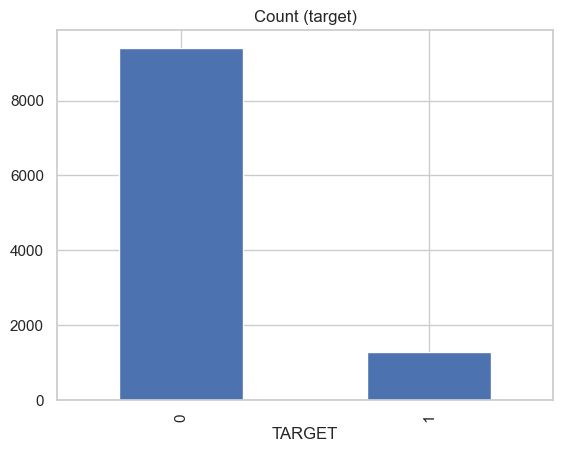

In [42]:
target_count = df_train["TARGET"].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [43]:
df_train_cat = df_train.loc[:, cat_features_mask]
df_train_real = df_train.drop(df_train_cat, axis=1)

df_test_cat = df_test.loc[:, cat_features_mask]
df_test_real = df_test.drop(df_train_cat, axis=1)

In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

ohe = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore', drop='first')
ohe.fit(df_train_cat)

result = ohe.transform(df_train_cat)
df_train_categorical_encoded = pd.DataFrame(result, columns=ohe.get_feature_names_out())

result_test = ohe.transform(df_test_cat)

df_test_categorical_encoded = pd.DataFrame(result_test, columns=ohe.get_feature_names_out())

normalizer = StandardScaler()

normalizer.fit(df_train_real.drop(columns="TARGET"))

df_train_real_standarted = pd.DataFrame(normalizer.transform(df_train_real.drop(columns="TARGET")),
                                        columns=normalizer.get_feature_names_out())

df_test_real_standarted = pd.DataFrame(normalizer.transform(df_test_real.drop(columns="TARGET")),
                                        columns=normalizer.get_feature_names_out())

X_train = df_train_real_standarted.join(df_train_categorical_encoded)
X_test = df_test_real_standarted.join(df_test_categorical_encoded)


y_train = df_train_real['TARGET']
y_test = df_test_real['TARGET']

In [45]:
X_test

,AGE,GENDER,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,FL_PRESENCE_FL,OWN_AUTO,PERSONAL_INCOME,LOAN_NUM_TOTAL,...,REG_ADDRESS_PROVINCE_Читинская область,REG_ADDRESS_PROVINCE_Чувашия,REG_ADDRESS_PROVINCE_Эвенкийский АО,REG_ADDRESS_PROVINCE_Якутия,REG_ADDRESS_PROVINCE_Ямало-Ненецкий АО,REG_ADDRESS_PROVINCE_Ярославская область,FAMILY_INCOME_от 10000 до 20000 руб.,FAMILY_INCOME_от 20000 до 50000 руб.,FAMILY_INCOME_от 5000 до 10000 руб.,FAMILY_INCOME_свыше 50000 руб.
0,0.744928,0.724421,-0.108746,-0.795815,0.313523,-0.391249,-0.672881,-0.361806,0.647514,-0.493944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.436190,0.724421,0.898185,-0.795815,-3.189558,2.555919,1.486147,-0.361806,-1.101252,-0.493944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.588082,-1.380412,-1.115676,-0.795815,0.313523,-0.391249,-0.672881,-0.361806,-0.205543,-0.493944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.983228,-1.380412,-1.115676,-0.795815,0.313523,-0.391249,1.486147,-0.361806,1.500570,-0.493944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.637596,-1.380412,-0.108746,0.431797,0.313523,-0.391249,1.486147,-0.361806,0.754146,0.748928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4625,-0.637596,-1.380412,-0.108746,0.431797,0.313523,-0.391249,-0.672881,2.758881,0.540882,-0.493944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4626,1.695414,0.724421,-0.108746,-0.795815,0.313523,2.555919,-0.672881,-0.361806,-0.386817,1.991799,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4627,0.485705,0.724421,0.898185,-0.795815,0.313523,-0.391249,1.486147,-0.361806,-0.632071,-0.493944,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4628,-1.156043,-1.380412,-0.108746,0.431797,0.313523,-0.391249,-0.672881,-0.361806,0.007721,-0.493944,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


model=LogisticRegression()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

Accuracy: 0.88207343412527
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.6492634193402159


In [47]:
from sklearn.metrics import classification_report

probs = model.predict_proba(X_test)[:,1]
classes = probs > 0.1


print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.93      0.45      0.61      4087
           1       0.16      0.76      0.26       543

    accuracy                           0.49      4630
   macro avg       0.55      0.61      0.43      4630
weighted avg       0.84      0.49      0.57      4630



Text(0.5, 1.0, 'Precision-Recall Curve')

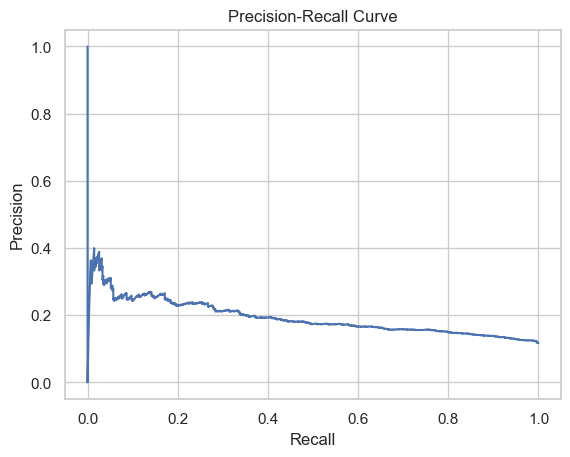

In [48]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

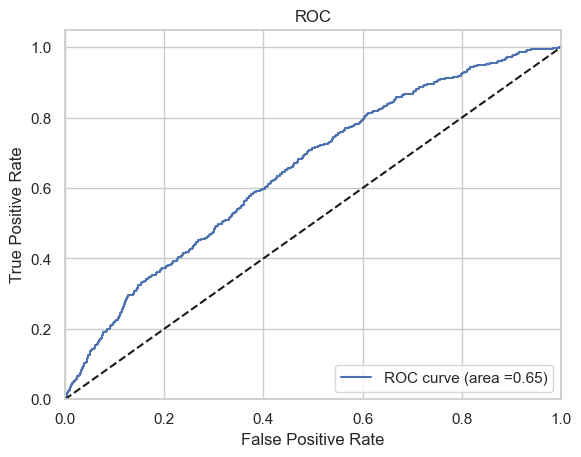

In [787]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area ={round(roc_auc,2)})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [997]:
max_recall = -1
best_thr = -1
acc = -1

for thr in np.arange(0, 1, 0.01):
    probs = model.predict_proba(X_test)[:,1]
    classes = probs > thr
    
    if recall_score(y_test, classes) > max_recall and accuracy_score(y_test, classes) > 0.6:
        max_recall = recall_score(y_test, classes)
        best_thr = thr
        acc = accuracy_score(y_test, classes)
        
max_recall, best_thr, acc

(0.5561694290976059, 0.13, 0.639524838012959)

In [994]:
probs = model.predict_proba(X_test)[:,1]
classes = probs > best_thr
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      4087
           1       0.17      0.56      0.27       543

    accuracy                           0.64      4630
   macro avg       0.55      0.60      0.51      4630
weighted avg       0.83      0.64      0.70      4630



## Создание пайплайна

In [948]:
from sklearn.pipeline import Pipeline

In [950]:
num_cols

['AGE',
 'GENDER',
 'CHILD_TOTAL',
 'DEPENDANTS',
 'SOCSTATUS_WORK_FL',
 'SOCSTATUS_PENS_FL',
 'FL_PRESENCE_FL',
 'OWN_AUTO',
 'AGREEMENT_RK',
 'PERSONAL_INCOME',
 'LOAN_NUM_TOTAL',
 'LOAN_NUM_CLOSED']

In [982]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)

df_test.drop_duplicates(inplace=True)


cat_features_mask = (df_train.dtypes == "object").values
cat_cols = list(df_train.iloc[:,cat_features_mask].columns)
num_cols = list(df_train.drop(columns=cat_cols).columns)
num_cols.remove('TARGET')

In [985]:
y_train = df_train['TARGET']
y_test = df_test['TARGET']

X_train = df_train.drop(columns='TARGET')
X_test = df_test.drop(columns='TARGET')

In [986]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False,
                              handle_unknown = 'ignore',
                              drop='first'), cat_cols)
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression())
    ]
)

In [1064]:
model = pipeline.fit(X_train, y_train)

In [1065]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

Accuracy: 0.88207343412527
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.648719990302991


In [999]:
probs = model.predict_proba(X_test)[:,1]
classes = probs > 0.13
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      4087
           1       0.17      0.56      0.27       543

    accuracy                           0.64      4630
   macro avg       0.55      0.60      0.51      4630
weighted avg       0.83      0.64      0.70      4630



In [1066]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, classes)
precision = precision_score(y_test, classes)
recall = recall_score(y_test, classes)
f1 = f1_score(y_test, classes)
roc_auc = roc_auc_score(y_test, y_proba)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

Accuracy: 0.639524838012959
Precision: 0.1745664739884393
Recall: 0.5561694290976059
F1 Score: 0.2657281126264848
ROC-AUC: 0.648719990302991


In [990]:
cat_cols = list(df_train_cat.columns)
num_cols = list(df_train_real.columns)

print(best_thr)

0.13


In [859]:
import pickle
import pathlib

models_folder = pathlib.Path('.').resolve().parent / 'models'

In [1034]:
pickle.dump(pipeline, (models_folder / 'pipeline.pkl').open('wb'))
pickle.dump(preprocessor, (models_folder /'preprocessor.pkl').open('wb'))

In [ ]:
pipeline

In [875]:
X_test.iloc[1,:].to_csv(pathlib.Path('.').resolve().parent / 'models' / 'test.csv')

In [908]:
testing = pd.read_csv(models_folder / 'test.csv', index_col=0, header=None).T